**By Akinde Kadjo**, 04/10/2023

**Introduction:** ABL1 ( or Tyrosine-protein kinase ABL) gene provides instructions for making a protein involved in many processes in cells throughout the body. In response to growth factors, cytokines, cell adhesion, DNA damage, oxidative stress, and other signals, ABL is activated to stimulate cell proliferation or differentiation, survival or death, retraction, or migration according to [Wang.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3993570/#:~:text=The%20mammalian%20ABL1%20gene%20encodes,death%2C%20retraction%2C%20or%20migration.)

**Objective:** The goal of this project is to use the [DUDE-E](https://dude.docking.org/targets/abl1) data set for target against ABL1 to build a model that can accurately distinguish Active ligands from Decoy ligands (similar properties to actives but are known to be non-binders)

# Import and Data Loading

In [ ]:
!pip install rdkit-pypi

In [2]:
#Importing all of the libraries that may be needed for the project
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBRegressor, XGBClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay,roc_auc_score,PrecisionRecallDisplay, RocCurveDisplay,f1_score

from sklearn import set_config
set_config(display='diagram')

import warnings
warnings.filterwarnings('ignore')

import tarfile
import gzip

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors

In [3]:
#Create a function to export the Physical properties of choice from the files files into a dataframe
def extract(file):
    suppl = Chem.SDMolSupplier(file)
    mol_len = len(suppl)
    df = pd.DataFrame()
    
    for i in range(mol_len):
        mol = suppl[i]
        if mol is not None:
            df.loc[i,'smiles'] = Chem.MolToSmiles(mol)
            df.loc[i,'chemblid'] = mol.GetProp('_Name')
            df.loc[i,'MW'] = Descriptors.ExactMolWt(mol)
            df.loc[i,'asphericity'] = rdMolDescriptors.CalcAsphericity(mol)
            df.loc[i,'eccentricity'] = rdMolDescriptors.CalcEccentricity(mol)
            df.loc[i,'sp3'] = rdMolDescriptors.CalcFractionCSP3(mol)
            df.loc[i,'inertia'] = rdMolDescriptors.CalcInertialShapeFactor(mol)
            df.loc[i,'asa'] = rdMolDescriptors.CalcLabuteASA(mol)
            df.loc[i,'ar_rings'] = rdMolDescriptors.CalcNumAromaticRings(mol)
            df.loc[i,'al_rings'] = rdMolDescriptors.CalcNumAliphaticRings(mol)
            df.loc[i,'stereoCenters'] = rdMolDescriptors.CalcNumAtomStereoCenters(mol)
            df.loc[i,'atoms'] = rdMolDescriptors.CalcNumAtoms(mol)
            df.loc[i,'heavyatoms'] = rdMolDescriptors.CalcNumHeavyAtoms(mol)
            df.loc[i,'pbf'] = rdMolDescriptors.CalcPBF(mol)
            df.loc[i,'gyration'] = rdMolDescriptors.CalcRadiusOfGyration(mol)
            df.loc[i,'tpsa'] = rdMolDescriptors.CalcTPSA(mol)
            df.loc[i,'logp'] = Descriptors.MolLogP(mol)
            df.loc[i,'h_bond_donor'] = Descriptors.NumHDonors(mol) 
            df.loc[i,'h_bond_acceptor'] = Descriptors.NumHAcceptors(mol)
            df.loc[i,'num_rotatable_bonds'] = Descriptors.NumRotatableBonds(mol) 
            df.loc[i,'net_charge'] = Chem.GetFormalCharge(mol)
    
    return df

In [6]:
active_df = extract('actives_final.sdf')
active_df.head(2)

,smiles,chemblid,MW,asphericity,eccentricity,sp3,inertia,asa,ar_rings,al_rings,...,atoms,heavyatoms,pbf,gyration,tpsa,logp,h_bond_donor,h_bond_acceptor,num_rotatable_bonds,net_charge
0,Nc1ncnc2c1c(-c1cccc(O)c1)cn2C1CCC1,CHEMBL355330,280.132411,0.280987,0.930127,0.250000,0.000656,121.616651,3.0,1.0,...,37.0,21.0,0.443367,3.376660,76.96,3.1111,2.0,5.0,2.0,0.0
1,COc1ccccc1Oc1ccc2n[nH]c(-c3nc4ccc(N5CCC([NH+]6...,CHEMBL211508,523.281601,0.699540,0.993622,0.354839,0.000410,227.484450,5.0,2.0,...,74.0,39.0,0.672138,6.448559,83.50,4.9447,3.0,5.0,6.0,1.0


In [8]:
decoy_df = extract('decoys_final.sdf')
decoy_df.head(2)

,smiles,chemblid,MW,asphericity,eccentricity,sp3,inertia,asa,ar_rings,al_rings,...,atoms,heavyatoms,pbf,gyration,tpsa,logp,h_bond_donor,h_bond_acceptor,num_rotatable_bonds,net_charge
0,C[C@@H]1CCCC[C@@]12NC(=O)N(CC(=O)Nc1ccc(C(N)=O...,ZINC02649438,358.164105,0.633763,0.989822,0.444444,0.001058,150.644583,1.0,2.0,...,48.0,26.0,0.629443,4.359138,121.60,1.2247,3.0,4.0,4.0,0.0
1,C=C1NN(c2nc3ccccc3s2)C(=O)[C@@H]1/C=N/C(CO)(CO)CO,ZINC01814196,362.104876,0.616234,0.988628,0.312500,0.000984,147.281501,2.0,1.0,...,43.0,25.0,0.299550,4.330039,118.28,0.0639,4.0,8.0,6.0,0.0


# Classification analysis

In this part, I'll use both active and decoy dataframe to predict how effective the compounds physical properties can be used to predict wether they are active or not against the target.

## Data Cleaning

Here, I'll add a target column of 1 for the active ligands and 0 for the decoys.

In [68]:
#Adding target column
active_df['target'] = 1
decoy_df['target'] = 0
#Concacenating both dfs
ligands_df =  pd.concat([active_df, decoy_df])
ligands_df.head(2)

,smiles,chemblid,molecular_weight,asphericity,eccentricity,sp3,inertia,asa,ar_rings,al_rings,...,heavyatoms,pbf,gyration,tpsa,logp,h_bond_donor,h_bond_acceptor,num_rotatable_bonds,net_charge,target
0,Nc1ncnc2c1c(-c1cccc(O)c1)cn2C1CCC1,CHEMBL355330,280.132411,0.280987,0.930127,0.250000,0.000656,121.616651,3.0,1.0,...,21.0,0.443367,3.376660,76.96,3.1111,2.0,5.0,2.0,0.0,1
1,COc1ccccc1Oc1ccc2n[nH]c(-c3nc4ccc(N5CCC([NH+]6...,CHEMBL211508,523.281601,0.699540,0.993622,0.354839,0.000410,227.484450,5.0,2.0,...,39.0,0.672138,6.448559,83.50,4.9447,3.0,5.0,6.0,1.0,1


In [69]:
ligands_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11180 entries, 0 to 10884
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   smiles               11180 non-null  object 
 1   chemblid             11180 non-null  object 
 2   molecular_weight     11180 non-null  float64
 3   asphericity          11180 non-null  float64
 4   eccentricity         11180 non-null  float64
 5   sp3                  11180 non-null  float64
 6   inertia              11180 non-null  float64
 7   asa                  11180 non-null  float64
 8   ar_rings             11180 non-null  float64
 9   al_rings             11180 non-null  float64
 10  stereoCenters        11180 non-null  float64
 11  atoms                11180 non-null  float64
 12  heavyatoms           11180 non-null  float64
 13  pbf                  11180 non-null  float64
 14  gyration             11180 non-null  float64
 15  tpsa                 11180 non-null 

In [70]:
#drop duplicates and check again
ligands_df = ligands_df.drop_duplicates()
ligands_df.duplicated().sum()

0

In [71]:
#moving forward with numeric columns
ligands_df = ligands_df.drop(columns=['smiles','chemblid'])
ligands_df.head(2)

,molecular_weight,asphericity,eccentricity,sp3,inertia,asa,ar_rings,al_rings,stereoCenters,atoms,heavyatoms,pbf,gyration,tpsa,logp,h_bond_donor,h_bond_acceptor,num_rotatable_bonds,net_charge,target
0,280.132411,0.280987,0.930127,0.250000,0.000656,121.616651,3.0,1.0,0.0,37.0,21.0,0.443367,3.376660,76.96,3.1111,2.0,5.0,2.0,0.0,1
1,523.281601,0.699540,0.993622,0.354839,0.000410,227.484450,5.0,2.0,0.0,74.0,39.0,0.672138,6.448559,83.50,4.9447,3.0,5.0,6.0,1.0,1


## Visual exploratory analysis


In [89]:
##Creating a function for plotting histogram of the features
def feat_plot(y_list, plot_df):
  y_len = len(y_list)
  plot_df_0 = plot_df.loc[plot_df['target'] == 0]
  plot_df_1 = plot_df.loc[plot_df['target'] == 1]
  fig, axes = plt.subplots(2,y_len, figsize = (30, 6),constrained_layout=True)
  axes = axes.ravel()
  for i in range(y_len):
    sns.histplot(ax = axes[i],  x= plot_df_1[y_list[i]],color='blue')
    axes[i].set_title(f'Active {y_list[i]}')
    sns.histplot(ax = axes[i+y_len],  x= plot_df_0[y_list[i]],color='red')
    axes[i+y_len].set_title(f'Decoy {y_list[i]}')    
  return plt.show()

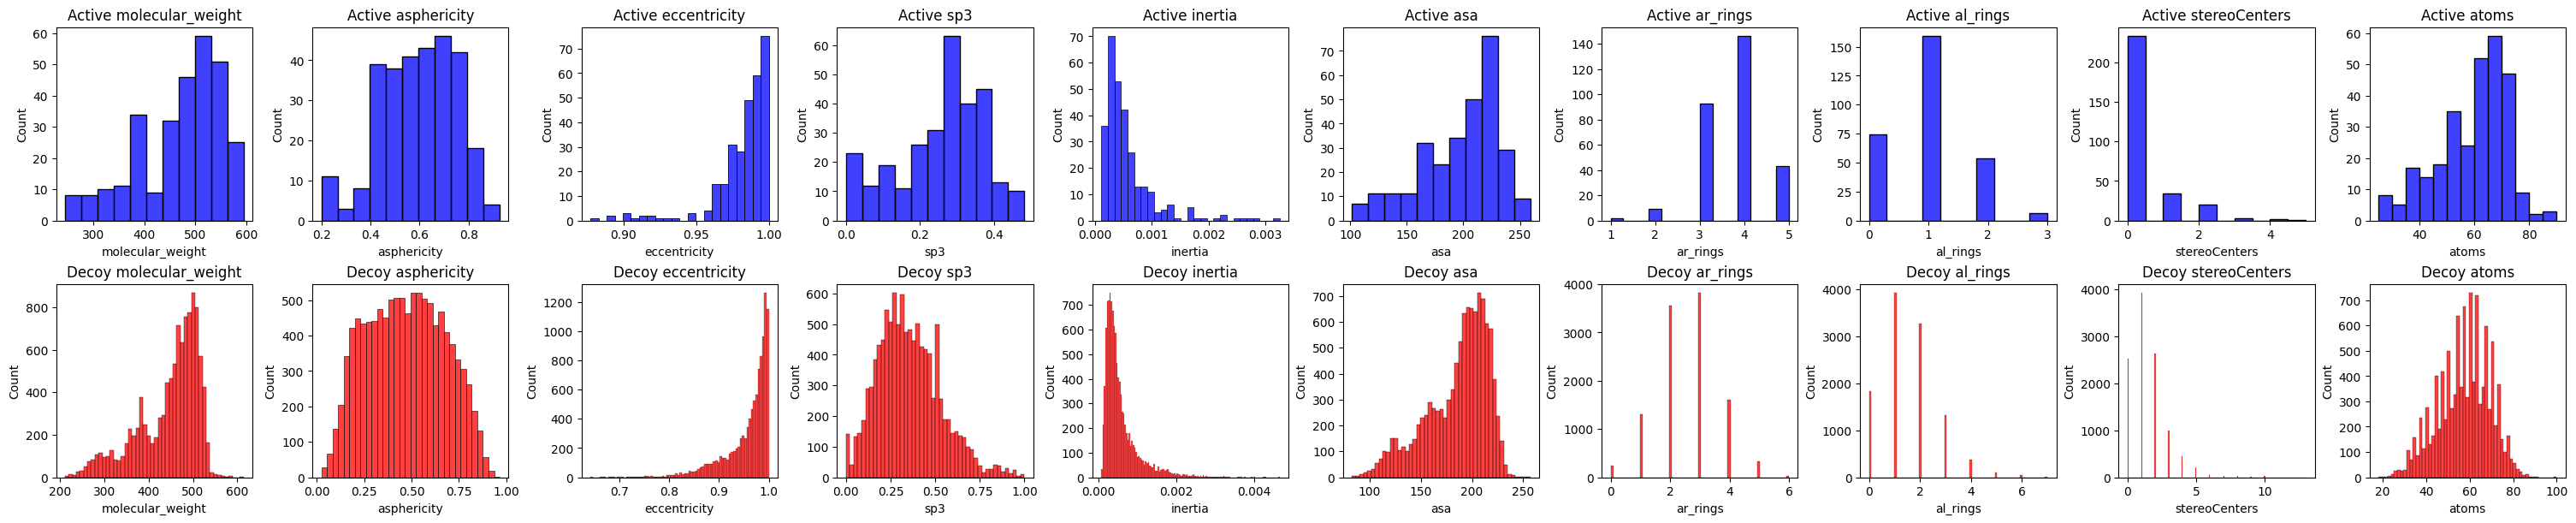

In [92]:
features = list(ligands_df.columns[:10])
feat_plot(features, ligands_df)

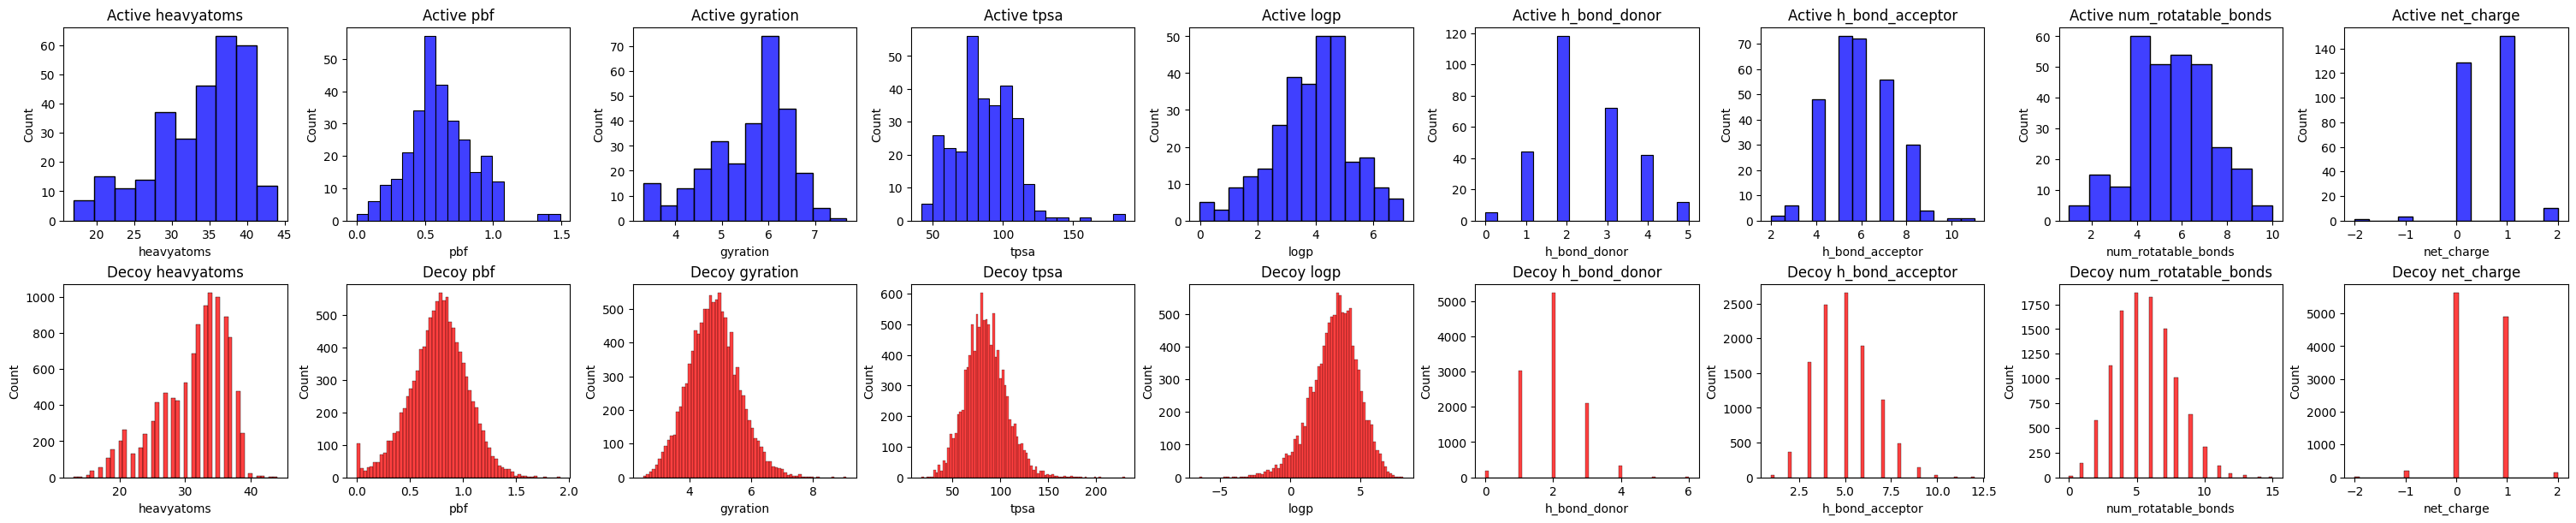

In [93]:
features = list(ligands_df.columns[10:-1])
feat_plot(features, ligands_df)

## ML Model

In [94]:
##I'm creating a function that will output the metrics for my model prediction evaluation
def evaluate_classiffication(model, X_test, y_test, label='Test Data', 
                             figsize=(15,5), normalize='true',
                             cmap='Blues'): 
                             
    fig, axes = plt.subplots(1,2, figsize=figsize)

    ## Get Predictions
    y_pred = model.predict(X_test)
     
   ## Print classification report for the test data (and make it pretty!)
    print('---'*20)
    print(f"[i] CLASSIFICATION REPORT FOR: {label}")
    print('---'*20)

    print(classification_report(y_test, y_pred))

    ConfusionMatrixDisplay.from_predictions(y_test,y_pred, 
                normalize=normalize, cmap=cmap,              
                ax=axes[0])    
    
    RocCurveDisplay.from_estimator(model, X_test, y_test,
                                   ax=axes[1])
    plt.show()

In [95]:
#is the data balanced?
ligands_df['target'].value_counts(normalize=True)

0    0.973778
1    0.026222
Name: target, dtype: float64

This dataset is unbalanced, so some type of tuning (add weight) will have to be applied

>Random forest model

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: the Test Data using Random Forest Regression
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2726
           1       0.97      0.46      0.62        68

    accuracy                           0.99      2794
   macro avg       0.98      0.73      0.81      2794
weighted avg       0.99      0.99      0.98      2794



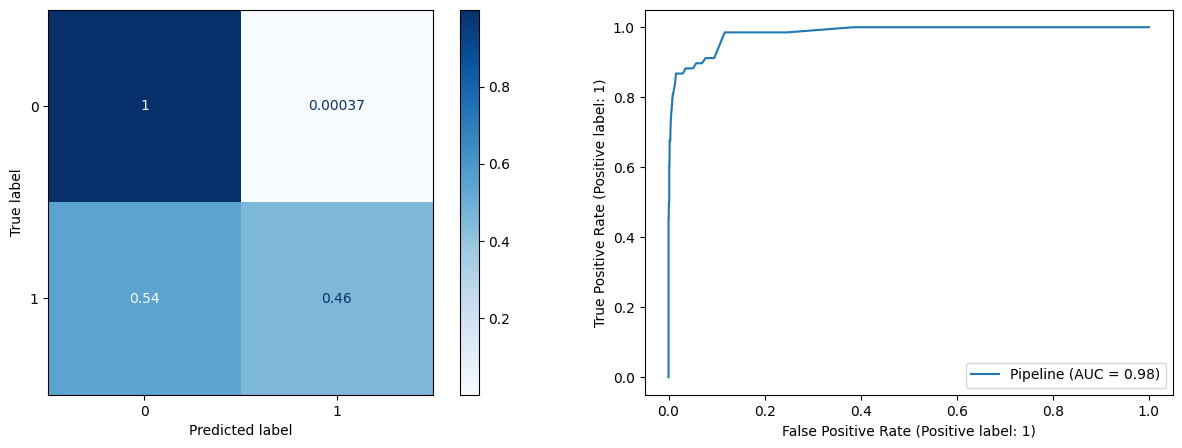

In [96]:
#Data Splitting and Preprocessing
y = ligands_df['target']
X = ligands_df.drop(columns='target')
#Performing a train test split, here the random state of 42 is chosen for consistency
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
# Instantiate Standard Scaler and random forest classification
scaler = StandardScaler() 
model = RandomForestClassifier(random_state=42)
# Setting up the pipeline and fitting the data
model_pipe = make_pipeline(scaler, model)
model_pipe.fit(X_train, y_train)
# Evaluating the model
evaluate_classiffication(model_pipe, X_test,y_test,label='the Test Data using Random Forest Regression')

Only 46% of the active ligands are predicted to be active, some tuning is needed here since the data is overwhelmingly unbalanced in favor of the decoy dataset

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: the Test Data using Random Forest Regression with weight
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2726
           1       0.93      0.57      0.71        68

    accuracy                           0.99      2794
   macro avg       0.96      0.79      0.85      2794
weighted avg       0.99      0.99      0.99      2794



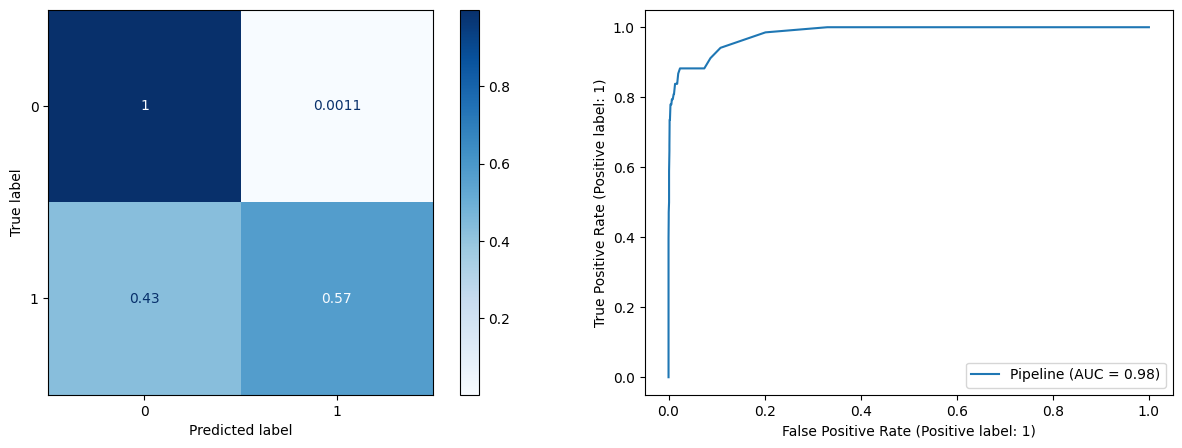

In [97]:
# Instantiate Standard Scaler and random forest classification
scaler = StandardScaler() 
model = RandomForestClassifier(random_state=42, class_weight= "balanced_subsample")
# Setting up the pipeline and fitting the data
model_pipe = make_pipeline(scaler, model)
model_pipe.fit(X_train, y_train)
# Evaluating the model
evaluate_classiffication(model_pipe, X_test,y_test,label='the Test Data using Random Forest Regression with weight')

>Adding weigth increased the recall to 57%.
>Undersampling of the decoy dataset and using SMOTE (Synthetic Minority Oversampling TEchnique)to oversample the active dataset could help with the imbalanced data and increase both the f1 score and the AUC. 

# Conclusion